In [1]:
import logging
import pathlib
import pickle
import re
import warnings
from collections import defaultdict

import attr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from joblib import Parallel, delayed
from plotnine import (
    aes,
    element_blank,
    element_rect,
    element_text,
    ggplot,
    stat_smooth,
    theme,
)
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.neighbors import NearestNeighbors

from skrough.base import Bireduct
from skrough.bireducts.dynamically_adapted_approximate_bireduct import (
    DynamicallyAdaptedApproximateBireduct,
)

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import config

In [3]:
DATA_DIR = pathlib.Path(config.DATA_DIR)
TMP_DIR = pathlib.Path(config.TMP_DIR)
SEP = ";"

# FILEPATH_IN = DATA_DIR / 'toolbox_tabular_data_annonymized_discretized_uniform.csv'
FILEPATH_IN = DATA_DIR / "toolbox_tabular_data_annonymized_discretized_quantile.csv"
# FILEPATH_IN = DATA_DIR / 'toolbox_tabular_data_annonymized_discretized_kmeans.csv'
# FILEPATH_IN = DATA_DIR / 'toolbox_tabular_data_annonymized.csv'

In [117]:
df = pd.read_csv(FILEPATH_IN, sep=SEP)
process_ids = df.pop("process_ids")
df = df.astype("category")
df = df.apply(lambda x: x.cat.codes)
df_dec = df.pop("target")
df_dec = 1 - df_dec

del df
del process_ids

In [6]:
sum(df_dec) / len(df_dec)

0.06968954656801479

In [257]:
FEATURE_GROUPS_FILEPATH_IN = DATA_DIR / "feature_groups.csv"

feature_groups = pd.read_csv(FEATURE_GROUPS_FILEPATH_IN)

group_names = [
    "employment history",
    "skills",
    "education",
    "place of residence",
    "current status",
    "job offer",
    "person-offer relation",
]

In [106]:
# result_xgboost_test = []
# for p in (TMP_DIR/'trash/paper_xgboost_hyper_native_2_test').glob('*.csv'):
#     m = re.search('_dataset_(\w+)'
#                   '_leave_one_process_out_k_(\d+).*_num_boost_round_(\d+).*_learning_rate_([.\d]+).*_max_depth_(\d+).*_base_score_([.\d]+).*\.csv', p.name)
#     if m is not None:
#         dataset = m.group(1)
#         k = int(m.group(2))
#         num_boost_round = int(m.group(3))
#         learning_rate = float(m.group(4))
#         max_depth = int(m.group(5))
#         base_score = float(m.group(6))
#         without_feature_group = m.group(7)
#         x = pd.read_csv(p, sep=';')
#         result_xgboost_test.append([dataset, k, num_boost_round, learning_rate, max_depth, base_score, without_feature_group,
#                        roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0]/x.iloc[:, 1]))])
# result_xgboost_test = pd.DataFrame(result_xgboost_test, columns=('dataset', 'k', 'num_boost_round', 'learning_rate', 'max_depth', 'base_score', 'without_feature_group', AUC'))
# result_xgboost_test = result_xgboost_test[result_xgboost_test['without_feature_group'].isnull()]
# result_xgboost_test.sort_values('AUC', ascending=False)

In [246]:
result_xgboost = []
for p in (TMP_DIR / "paper_xgboost_hyper_native_2_").glob("*.csv"):
    m = re.search(
        r"_dataset_(\w+)"
        r"_leave_one_process_out_k_(\d+).*_num_boost_round_(\d+).*_learning_rate_([.\d]+).*_max_depth_(\d+).*_base_score_([.\d]+).*?(?:_without_feature_group_(.*))?\.csv",
        p.name,
    )
    if m is not None:
        dataset = m.group(1)
        k = int(m.group(2))
        num_boost_round = int(m.group(3))
        learning_rate = float(m.group(4))
        max_depth = int(m.group(5))
        base_score = float(m.group(6))
        without_feature_group = m.group(7)
        x = pd.read_csv(p, sep=";")
        result_xgboost.append(
            [
                dataset,
                k,
                num_boost_round,
                learning_rate,
                max_depth,
                base_score,
                without_feature_group,
                roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 1])),
            ]
        )
result_xgboost = pd.DataFrame(
    result_xgboost,
    columns=(
        "dataset",
        "k",
        "num_boost_round",
        "learning_rate",
        "max_depth",
        "base_score",
        "without_feature_group",
        "AUC",
    ),
)
result_xgboost = result_xgboost[result_xgboost["without_feature_group"].isnull()]

In [623]:
# result_tree_test = []
# for p in (TMP_DIR/'paper_tree_2_test').glob('*.csv'):
#     m = re.search('_dataset_(\w+)'
#                   '_leave_one_process_out_k_(\d+).*_min_impurity_decrease_([.\d]+).*_max_depth_(\d+|None).*?(?:_without_feature_group_(.*))?\.csv', p.name)
#     if m is not None:
#         dataset = m.group(1)
#         k = int(m.group(2))
#         min_impurity_decrease = float(m.group(3))
#         max_depth = None if m.group(4) == 'None' else int(m.group(4))
#         without_feature_group = m.group(5)
#         x = pd.read_csv(p, sep=';')
#         result_tree_test.append([dataset, k, min_impurity_decrease, max_depth, without_feature_group,
#                        roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0]/x.iloc[:, 1]))])
# result_tree_test = pd.DataFrame(result_tree_test, columns=('dataset', 'k', 'min_impurity_decrease', 'max_depth', 'without_feature_group', AUC'))
# result_tree_test = result_tree_test[result_tree_test['without_feature_group'].isnull()]
# result_tree_test.sort_values('AUC', ascending=False)

In [84]:
# result_tree_2 = []
# for p in (TMP_DIR/'trash/paper_tree_2_').glob('*.csv'):
#     m = re.search('_dataset_(\w+)'
#                   '_leave_one_process_out_k_(\d+).*_min_impurity_decrease_([.\d]+).*_max_depth_(\d+|None).*?(?:_without_feature_group_(.*))?\.csv', p.name)
#     if m is not None:
#         dataset = m.group(1)
#         k = int(m.group(2))
#         min_impurity_decrease = float(m.group(3))
#         max_depth = None if m.group(4) == 'None' else int(m.group(4))
#         without_feature_group = m.group(5)
#         x = pd.read_csv(p, sep=';')
#         result_tree_2.append([dataset, k, min_impurity_decrease, max_depth, without_feature_group,
#                        roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0]/x.iloc[:, 1]))])
# result_tree_2 = pd.DataFrame(result_tree_2, columns=('dataset', 'k', 'min_impurity_decrease', 'max_depth', 'without_feature_group', AUC'))
# result_tree_2 = result_tree_2[result_tree_2['without_feature_group'].isnull()]

In [247]:
result_tree = []
for p in (TMP_DIR / "paper_tree_3_").glob("*.csv"):
    m = re.search(
        r"_dataset_(\w+)"
        r"_leave_one_process_out_k_(\d+).*_min_impurity_decrease_([.\d]+).*_max_depth_(\d+|None).*?(?:_without_feature_group_(.*))?\.csv",
        p.name,
    )
    if m is not None:
        dataset = m.group(1)
        k = int(m.group(2))
        min_impurity_decrease = float(m.group(3))
        max_depth = None if m.group(4) == "None" else int(m.group(4))
        without_feature_group = m.group(5)
        x = pd.read_csv(p, sep=";")
        result_tree.append(
            [
                dataset,
                k,
                min_impurity_decrease,
                max_depth,
                without_feature_group,
                roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 1])),
            ]
        )
result_tree = pd.DataFrame(
    result_tree,
    columns=(
        "dataset",
        "k",
        "min_impurity_decrease",
        "max_depth",
        "without_feature_group",
        "AUC",
    ),
)
result_tree = result_tree[result_tree["without_feature_group"].isnull()]

In [249]:
result_bireducts = []
for p in (TMP_DIR / "paper_bireducts_2_").glob("*.csv"):
    m = re.search(
        r"_dataset_(\w+)"
        r"_leave_one_process_out_k_(\d+).*_n_bireducts_(\d+).*_candidate_n_attrs_(\d+).*_allowed_randomness_([.\d]+).*_max_n_attrs_(\d+|None).*_iteration_(\d+).*?(?:_without_feature_group_(.*))?\.csv",
        p.name,
    )
    if m is not None:
        dataset = m.group(1)
        k = int(m.group(2))
        n_bireducts = int(m.group(3))
        candidate_n_attrs = int(m.group(4))
        allowed_randomness = float(m.group(5))
        max_n_attrs = None if m.group(6) == "None" else int(m.group(6))
        iteration = int(m.group(7))
        without_feature_group = m.group(8)
        x = pd.read_csv(p, sep=";")
        result_bireducts.append(
            [
                dataset,
                k,
                n_bireducts,
                candidate_n_attrs,
                allowed_randomness,
                max_n_attrs,
                iteration,
                without_feature_group,
                roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 1])),
                roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 2])),
            ]
        )
result_bireducts = pd.DataFrame(
    result_bireducts,
    columns=(
        "dataset",
        "k",
        "n_bireducts",
        "candidate_n_attrs",
        "allowed_randomness",
        "max_n_attrs",
        "iteration",
        "without_feature_group",
        "AUC",
        "AUC2",
    ),
)
result_bireducts = result_bireducts[result_bireducts["without_feature_group"].isnull()]

In [8]:
# result_bireducts_old = []
# for p in (TMP_DIR/'paper').glob('*.csv'):
#     m = re.search('k_(\d+).*_bireducts_(\d+).*_candidate_attrs_(\d+).*_allowed_randomness_([.\d]+).*_rep_(\d+).*?(?:_without_feature_group_(.*))?\.csv', p.name)
#     if m is not None:
#         k = int(m.group(1))
#         bireducts = int(m.group(2))
#         candidate_attrs = int(m.group(3))
#         allowed_randomness = float(m.group(4))
#         iteration = int(m.group(5))
#         without_feature_group = m.group(6)
#         x = pd.read_csv(p, sep=';')
#         result_bireducts_old.append([k, bireducts, candidate_attrs,
#                                      allowed_randomness, iteration, without_feature_group,
#                                      1-roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0]/x.iloc[:, 1])),
#                                      1-roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0]/x.iloc[:, 2])),
#                                     ])
# result_bireducts_old = pd.DataFrame(result_bireducts_old, columns=('k', 'bireducts', 'candidate_attrs',
#                                                                    'allowed_randomness', 'iteration', 'without_feature_group',
#                                                                    'AUC', 'AUC2'))
# result_bireducts_old = result_bireducts_old[result_bireducts_old['without_feature_group'].isnull()]

In [9]:
# result_bireducts_old_3 = []
# for p in (TMP_DIR/'paper_max_3_attrs').glob('*.csv'):
#     m = re.search('k_(\d+).*_bireducts_(\d+).*_candidate_attrs_(\d+).*_allowed_randomness_([.\d]+).*_max_attrs_(\d+).*_rep_(\d+).*?(?:_without_feature_group_(.*))?\.csv', p.name)
#     if m is not None:
#         k = int(m.group(1))
#         bireducts = int(m.group(2))
#         candidate_attrs = int(m.group(3))
#         allowed_randomness = float(m.group(4))
#         max_attrs = int(m.group(5))
#         iteration = int(m.group(6))
#         without_feature_group = m.group(7)
#         x = pd.read_csv(p, sep=';')
#         result_bireducts_old_3.append([k, bireducts, candidate_attrs,
#                                      allowed_randomness, max_attrs, iteration, without_feature_group,
#                                      1-roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0]/x.iloc[:, 1])),
#                                      1-roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0]/x.iloc[:, 2])),
#                                     ])
# result_bireducts_old_3 = pd.DataFrame(result_bireducts_old_3, columns=('k', 'bireducts', 'candidate_attrs',
#                                                                        'allowed_randomness', 'max_attrs', 'iteration', 'without_feature_group',
#                                                                        'AUC', 'AUC2'))
# result_bireducts_old_3 = result_bireducts_old_3[result_bireducts_old_3['without_feature_group'].isnull()]

In [91]:
# x2 = result_xgboost[(result_xgboost['num_boost_round'] == 1000) & (result_xgboost['learning_rate'] == 0.001) & (result_xgboost['max_depth'] == 2) & (result_xgboost['base_score'] == 0.0696)]
# x3 = result_xgboost[(result_xgboost['num_boost_round'] == 1000) & (result_xgboost['learning_rate'] == 0.001) & (result_xgboost['max_depth'] == 3) & (result_xgboost['base_score'] == 0.0696)]
# x4 = result_xgboost[(result_xgboost['num_boost_round'] == 1000) & (result_xgboost['learning_rate'] == 0.001) & (result_xgboost['max_depth'] == 4) & (result_xgboost['base_score'] == 0.0696)]
# x5 = result_xgboost[(result_xgboost['num_boost_round'] == 1000) & (result_xgboost['learning_rate'] == 0.001) & (result_xgboost['max_depth'] == 5) & (result_xgboost['base_score'] == 0.0696)]
# x10 = result_xgboost[(result_xgboost['num_boost_round'] == 1000) & (result_xgboost['learning_rate'] == 0.001) & (result_xgboost['max_depth'] == 10) & (result_xgboost['base_score'] == 0.0696)]

x3 = result_xgboost[
    (result_xgboost["dataset"] == "toolbox_tabular_data_annonymized")
    & (result_xgboost["num_boost_round"] == 1000)
    & (result_xgboost["learning_rate"] == 0.001)
    & (result_xgboost["max_depth"] == 3)
    & (result_xgboost["base_score"] == 0.0696)
]
x2_discretized = result_xgboost[
    (
        result_xgboost["dataset"]
        == "toolbox_tabular_data_annonymized_discretized_quantile"
    )
    & (result_xgboost["num_boost_round"] == 1000)
    & (result_xgboost["learning_rate"] == 0.001)
    & (result_xgboost["max_depth"] == 2)
    & (result_xgboost["base_score"] == 0.0696)
]

t1 = result_tree[
    (result_tree["dataset"] == "toolbox_tabular_data_annonymized")
    & (result_tree["min_impurity_decrease"] == 0.0)
    & (result_tree["max_depth"] == 2)
]
t2 = result_tree[
    (result_tree["dataset"] == "toolbox_tabular_data_annonymized")
    & (result_tree["min_impurity_decrease"] == 0.001)
    & (result_tree["max_depth"] == 2)
]
t3 = result_tree[
    (result_tree["dataset"] == "toolbox_tabular_data_annonymized")
    & (result_tree["min_impurity_decrease"] == 0.0)
    & (result_tree["max_depth"] == 3)
]
t4 = result_tree[
    (result_tree["dataset"] == "toolbox_tabular_data_annonymized")
    & (result_tree["min_impurity_decrease"] == 0.001)
    & (result_tree["max_depth"] == 3)
]
t5 = result_tree[
    (result_tree["dataset"] == "toolbox_tabular_data_annonymized")
    & (result_tree["min_impurity_decrease"] == 0.0)
    & (result_tree["max_depth"] == 4)
]
t6 = result_tree[
    (result_tree["dataset"] == "toolbox_tabular_data_annonymized")
    & (result_tree["min_impurity_decrease"] == 0.001)
    & (result_tree["max_depth"] == 4)
]
t7 = result_tree[
    (result_tree["dataset"] == "toolbox_tabular_data_annonymized")
    & (result_tree["min_impurity_decrease"] == 0.0)
    & (result_tree["max_depth"] == 5)
]
t8 = result_tree[
    (result_tree["dataset"] == "toolbox_tabular_data_annonymized")
    & (result_tree["min_impurity_decrease"] == 0.001)
    & (result_tree["max_depth"] == 5)
]

# u1 = result_tree_2[(result_tree_2['dataset']=='toolbox_tabular_data_annonymized') &
#                    (result_tree_2['min_impurity_decrease'] == 0.0) & (result_tree_2['max_depth'] == 2)]
# u2 = result_tree_2[(result_tree_2['dataset']=='toolbox_tabular_data_annonymized') &
#                    (result_tree_2['min_impurity_decrease'] == 0.001) & (result_tree_2['max_depth'] == 2)]
# u3 = result_tree_2[(result_tree_2['dataset']=='toolbox_tabular_data_annonymized') &
#                    (result_tree_2['min_impurity_decrease'] == 0.0) & (result_tree_2['max_depth'] == 3)]
# u4 = result_tree_2[(result_tree_2['dataset']=='toolbox_tabular_data_annonymized') &
#                    (result_tree_2['min_impurity_decrease'] == 0.001) & (result_tree_2['max_depth'] == 3)]
# u5 = result_tree_2[(result_tree_2['dataset']=='toolbox_tabular_data_annonymized') &
#                    (result_tree_2['min_impurity_decrease'] == 0.0) & (result_tree_2['max_depth'] == 4)]
# u6 = result_tree_2[(result_tree_2['dataset']=='toolbox_tabular_data_annonymized') &
#                    (result_tree_2['min_impurity_decrease'] == 0.001) & (result_tree_2['max_depth'] == 4)]
# u7 = result_tree_2[(result_tree_2['dataset']=='toolbox_tabular_data_annonymized') &
#                    (result_tree_2['min_impurity_decrease'] == 0.0) & (result_tree_2['max_depth'] == 5)]
# u8 = result_tree_2[(result_tree_2['dataset']=='toolbox_tabular_data_annonymized') &
#                    (result_tree_2['min_impurity_decrease'] == 0.001) & (result_tree_2['max_depth'] == 5)]

b1 = result_bireducts[
    (result_bireducts["max_n_attrs"].isnull()) & (result_bireducts["iteration"] == 0)
]
b2 = result_bireducts[
    (result_bireducts["max_n_attrs"] == 3) & (result_bireducts["iteration"] == 1)
]

# bo1 = result_bireducts_old[result_bireducts_old['iteration'] == 0]
# bo2 = result_bireducts_old[result_bireducts_old['iteration'] == 1]
# bo3 = result_bireducts_old[result_bireducts_old['iteration'] == 2]
# bo4 = result_bireducts_old[result_bireducts_old['iteration'] == 3]
# bo5 = result_bireducts_old[result_bireducts_old['iteration'] == 4]

# bo31 = result_bireducts_old_3[result_bireducts_old_3['iteration'] == 0]
# bo32 = result_bireducts_old_3[result_bireducts_old_3['iteration'] == 1]
# bo33 = result_bireducts_old_3[result_bireducts_old_3['iteration'] == 2]
# bo34 = result_bireducts_old_3[result_bireducts_old_3['iteration'] == 3]
# bo35 = result_bireducts_old_3[result_bireducts_old_3['iteration'] == 4]

<AxesSubplot:xlabel='k', ylabel='AUC'>

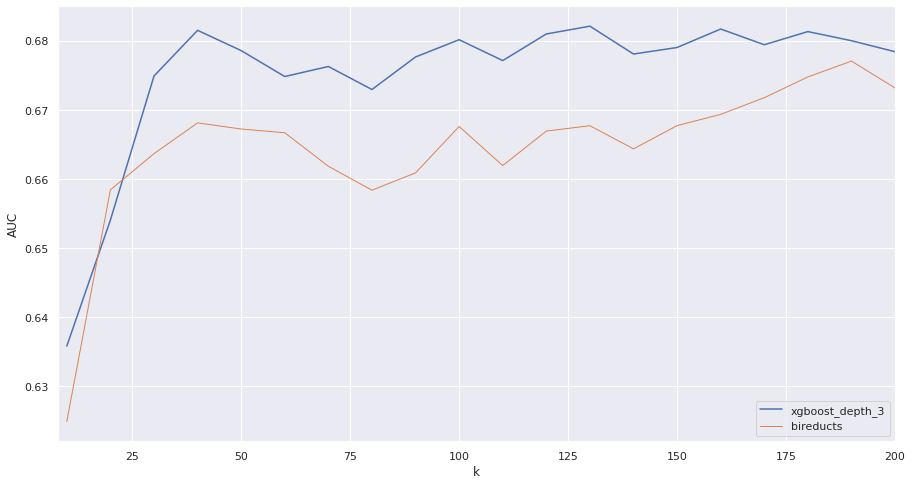

In [109]:
sns.set_theme()
plt.figure(figsize=(15, 8))
plt.xlim(8, 200)

sns.lineplot(data=x3, x="k", y="AUC", markers=True, label="xgboost_depth_3")
# sns.lineplot(data=x2_discretized, x='k', y='AUC', markers=True, label='xgboost_depth_2_discretized')
# sns.lineplot(data=x2, x='k', y='AUC', markers=True, lw=1, label='xgboost')
# sns.lineplot(data=x3, x='k', y='AUC', markers=True, lw=1, label='xgboost')
# sns.lineplot(data=x5, x='k', y='AUC', markers=True, lw=1, label='xgboost_depth_5')
# sns.lineplot(data=x5, x='k', y='AUC', markers=True, lw=1, label='xgboost')

sns.lineplot(data=b1, x="k", y="AUC", markers=True, lw=1, label="bireducts")
# sns.lineplot(data=b2, x='k', y='AUC', markers=True, lw=1, label='bireducts_attrs_3')

# sns.lineplot(data=bo1, x='k', y='AUC', markers=True, lw=1, color='red', label='bireducts_old')
# sns.lineplot(data=bo2, x='k', y='AUC', markers=True, lw=1, color='red')
# sns.lineplot(data=bo3, x='k', y='AUC', markers=True, lw=1, color='red')
# sns.lineplot(data=bo4, x='k', y='AUC', markers=True, lw=1, color='red')
# sns.lineplot(data=bo5, x='k', y='AUC', markers=True, lw=1, color='red')

# sns.lineplot(data=result_bireducts_old, x='k', y='AUC', markers=True, lw=1, label='bireducts_old')

# sns.lineplot(data=bo31, x='k', y='AUC', markers=True, lw=1, color='plum', label='bireducts_old_3')
# sns.lineplot(data=bo32, x='k', y='AUC', markers=True, lw=1, color='plum')
# sns.lineplot(data=bo33, x='k', y='AUC', markers=True, lw=1, color='plum')
# sns.lineplot(data=bo34, x='k', y='AUC', markers=True, lw=1, color='plum')
# sns.lineplot(data=bo35, x='k', y='AUC', markers=True, lw=1, color='plum')

# sns.lineplot(data=result_bireducts_old_3, x='k', y='AUC', markers=True, lw=1, label='bireducts_old_3')

# sns.lineplot(data=t1, x='k', y='AUC', markers=True, lw=1, label='tree')
# sns.lineplot(data=t2, x='k', y='AUC', markers=True, lw=1)
# sns.lineplot(data=t3, x='k', y='AUC', markers=True, lw=1, label='3')
# sns.lineplot(data=t4, x='k', y='AUC', markers=True, lw=1)
# sns.lineplot(data=t5, x='k', y='AUC', markers=True, lw=1, label='5')
# sns.lineplot(data=t6, x='k', y='AUC', markers=True, lw=1)
# sns.lineplot(data=t7, x='k', y='AUC', markers=True, lw=1, label='7')
# sns.lineplot(data=t8, x='k', y='AUC', markers=True, lw=1)

# sns.lineplot(data=u3, x='k', y='AUC', markers=True, lw=1, label='7')

In [284]:
# (ggplot()
#  + stat_smooth(data=x3, mapping=aes('k', 'AUC'), method='loess', color='royalblue', size=2, span=0.3)
#  + stat_smooth(data=b1, mapping=aes('k', 'AUC'), method='loess', color='limegreen', size=2, span=0.3)
#  + stat_smooth(data=t7, mapping=aes('k', 'AUC'), method='loess', color='tomato', size=2, span=0.3)
# )

In [99]:
valx = x3[["k", "AUC"]].copy()
valx["algorithm"] = "xgboost"
valb = b1[["k", "AUC"]].copy()
valb["algorithm"] = "bireducts"
valt = t7[["k", "AUC"]].copy()
valt["algorithm"] = "decision tree"

vals = pd.concat([valx, valb, valt])

In [100]:
vals.to_csv("auc_vals.csv", index=False)

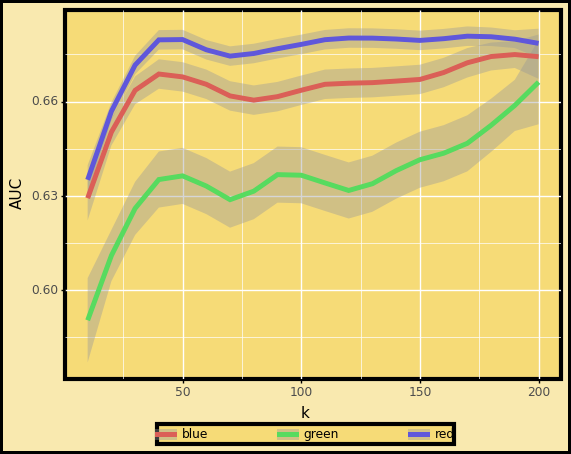

<ggplot: (8761881125208)>

In [101]:
plot = (
    ggplot(vals, aes(x="k"))
    + stat_smooth(
        aes(
            y="AUC",
            color=["red"] * 20 + ["blue"] * 20 + ["green"] * 20,
            group="algorithm",
        ),
        span=0.4,
        size=2,
        level=0.95,
    )
    + theme(
        legend_direction="horizontal",
        legend_position="bottom",
        legend_key=element_rect(alpha=0),
        legend_title=element_blank(),
        legend_entry_spacing_x=50,
        legend_box_margin=-3,
        legend_box_spacing=0.45,
        rect=element_rect(color="black", size=3, fill="#EEBB0050"),
    )
)
plot

In [102]:
# plot.save('kresults_span_04.pdf')

# Predictions

In [72]:
def get_predictions(file_path, norm_column=1):
    df = pd.read_csv(file_path, sep=";")
    return df.iloc[:, 0] / df.iloc[:, 1]


def get_predictions_metrics(df_dec, preds, round_decimals=3):
    precision, recall, thresholds = precision_recall_curve(df_dec, preds)
    f1_score = np.divide(
        2 * recall * precision,
        recall + precision,
        out=np.zeros(len(precision)),
        where=(recall + precision > 0),
    )
    i = np.argmax(f1_score)
    #     sns.lineplot(x=range(len(f1_score)), y=f1_score, label='f1_score')
    return {
        "precision": np.round(precision[i], decimals=round_decimals),
        "recall": np.round(recall[i], decimals=round_decimals),
        "f1_score": np.round(f1_score[i], decimals=round_decimals),
        "AUC": np.round(roc_auc_score(df_dec, preds), decimals=round_decimals),
    }


def get_predictions_table(df_dec, preds_all, preds_same, preds_40, round_decimal=3):
    table = pd.DataFrame.from_dict(
        {
            "all": get_predictions_metrics(df_dec, preds_all),
            "same": get_predictions_metrics(df_dec, preds_same),
            "top 40": get_predictions_metrics(df_dec, preds_40),
        },
        orient="index",
    )
    table = table.T
    return table

In [93]:
pred_xgboost_all = get_predictions(
    "./tmp/paper_xgboost_hyper_native_2_/xgboost_native_dataset_toolbox_tabular_data_annonymized"
    "_leave_one_process_out_k_None_num_boost_round_1000_learning_rate_0.001_max_depth_3_base_score_0.0696.csv"
)
pred_xgboost_same = get_predictions(
    "./tmp/paper_xgboost_hyper_native_2_/xgboost_native_dataset_toolbox_tabular_data_annonymized"
    "_leave_one_process_out_same_category_num_boost_round_1000_learning_rate_0.001_max_depth_3_base_score_0.0696.csv"
)
pred_xgboost_40 = get_predictions(
    "./tmp/paper_xgboost_hyper_native_2_/xgboost_native_dataset_toolbox_tabular_data_annonymized"
    "_leave_one_process_out_k_40_num_boost_round_1000_learning_rate_0.001_max_depth_3_base_score_0.0696.csv"
)


pred_tree_all = get_predictions(
    "./tmp/paper_tree_3_/decision_tree_dataset_toolbox_tabular_data_annonymized"
    "_leave_one_process_out_k_None_min_impurity_decrease_0.0_max_depth_5.csv"
)
pred_tree_same = get_predictions(
    "./tmp/paper_tree_3_/decision_tree_dataset_toolbox_tabular_data_annonymized"
    "_leave_one_process_out_same_category_min_impurity_decrease_0.0_max_depth_5.csv"
)
pred_tree_40 = get_predictions(
    "./tmp/paper_tree_3_/decision_tree_dataset_toolbox_tabular_data_annonymized"
    "_leave_one_process_out_k_40_min_impurity_decrease_0.0_max_depth_5.csv"
)


pred_bireducts_all = get_predictions(
    "./tmp/paper_bireducts_2_/bireducts_dataset_toolbox_tabular_data_annonymized_discretized_quantile"
    "_leave_one_process_out_k_None_n_bireducts_1000_candidate_n_attrs_100_allowed_randomness_0.05_max_n_attrs_None_iteration_0.csv"
)
pred_bireducts_same = get_predictions(
    "./tmp/paper_bireducts_2_/bireducts_dataset_toolbox_tabular_data_annonymized_discretized_quantile"
    "_leave_one_process_out_same_category_n_bireducts_1000_candidate_n_attrs_100_allowed_randomness_0.05_max_n_attrs_None_iteration_0.csv"
)
pred_bireducts_40 = get_predictions(
    "./tmp/paper_bireducts_2_/bireducts_dataset_toolbox_tabular_data_annonymized_discretized_quantile"
    "_leave_one_process_out_k_40_n_bireducts_1000_candidate_n_attrs_100_allowed_randomness_0.05_max_n_attrs_None_iteration_0.csv"
)

In [103]:
pred_xgboost_all = get_predictions(
    "./tmp/paper_xgboost_hyper_native_2_/xgboost_native_dataset_toolbox_tabular_data_annonymized"
    "_leave_one_process_out_k_None_num_boost_round_1000_learning_rate_0.001_max_depth_3_base_score_0.0696.csv"
)
pred_xgboost_same = get_predictions(
    "./tmp/paper_xgboost_hyper_native_2_/xgboost_native_dataset_toolbox_tabular_data_annonymized"
    "_leave_one_process_out_same_category_num_boost_round_1000_learning_rate_0.001_max_depth_3_base_score_0.0696.csv"
)
pred_xgboost_40 = get_predictions(
    "./tmp/paper_xgboost_hyper_native_2_/xgboost_native_dataset_toolbox_tabular_data_annonymized"
    "_leave_one_process_out_k_40_num_boost_round_1000_learning_rate_0.001_max_depth_3_base_score_0.0696.csv"
)

print(
    get_predictions_table(
        df_dec, pred_xgboost_all, pred_xgboost_same, pred_xgboost_40
    ).to_latex()
)

\begin{tabular}{lrrr}
\toprule
{} &    all &   same &  top 40 \\
\midrule
precision &  0.162 &  0.138 &   0.154 \\
recall    &  0.391 &  0.341 &   0.445 \\
f1\_score  &  0.229 &  0.197 &   0.229 \\
AUC       &  0.679 &  0.622 &   0.682 \\
\bottomrule
\end{tabular}



In [787]:
get_predictions_metrics(df_dec, pred_xgboost_all)

{'precision': 0.162, 'recall': 0.391, 'f1_score': 0.229, 'AUC': 0.679}

In [789]:
get_predictions_metrics(df_dec, pred_xgboost_same)

{'precision': 0.138, 'recall': 0.341, 'f1_score': 0.197, 'AUC': 0.622}

In [790]:
get_predictions_metrics(df_dec, pred_xgboost_40)

{'precision': 0.154, 'recall': 0.445, 'f1_score': 0.229, 'AUC': 0.682}

In [809]:
print(
    get_predictions_table(
        df_dec, pred_xgboost_all, pred_xgboost_same, pred_xgboost_40
    ).to_latex()
)

\begin{tabular}{lrrr}
\toprule
{} &    all &   same &  top 40 \\
\midrule
precision &  0.162 &  0.138 &   0.154 \\
recall    &  0.391 &  0.341 &   0.445 \\
f1\_score  &  0.229 &  0.197 &   0.229 \\
AUC       &  0.679 &  0.622 &   0.682 \\
\bottomrule
\end{tabular}



In [95]:
get_predictions_metrics(df_dec, pred_tree_all)

{'precision': 0.131, 'recall': 0.551, 'f1_score': 0.211, 'AUC': 0.659}

In [96]:
get_predictions_metrics(df_dec, pred_tree_same)

{'precision': 0.124, 'recall': 0.352, 'f1_score': 0.183, 'AUC': 0.558}

In [97]:
get_predictions_metrics(df_dec, pred_tree_40)

{'precision': 0.141, 'recall': 0.362, 'f1_score': 0.203, 'AUC': 0.63}

In [98]:
print(
    get_predictions_table(
        df_dec, pred_tree_all, pred_tree_same, pred_tree_40
    ).to_latex()
)

\begin{tabular}{lrrr}
\toprule
{} &    all &   same &  top 40 \\
\midrule
precision &  0.131 &  0.124 &   0.141 \\
recall    &  0.551 &  0.352 &   0.362 \\
f1\_score  &  0.211 &  0.183 &   0.203 \\
AUC       &  0.659 &  0.558 &   0.630 \\
\bottomrule
\end{tabular}



In [812]:
get_predictions_metrics(df_dec, pred_bireducts_all)

{'precision': 0.144, 'recall': 0.468, 'f1_score': 0.22, 'AUC': 0.671}

In [813]:
get_predictions_metrics(df_dec, pred_bireducts_same)

{'precision': 0.128, 'recall': 0.445, 'f1_score': 0.199, 'AUC': 0.63}

In [814]:
get_predictions_metrics(df_dec, pred_bireducts_40)

{'precision': 0.147, 'recall': 0.419, 'f1_score': 0.217, 'AUC': 0.668}

In [816]:
print(
    get_predictions_table(
        df_dec, pred_bireducts_all, pred_bireducts_same, pred_bireducts_40
    ).to_latex()
)

\begin{tabular}{lrrr}
\toprule
{} &    all &   same &  top 40 \\
\midrule
precision &  0.144 &  0.128 &   0.147 \\
recall    &  0.468 &  0.445 &   0.419 \\
f1\_score  &  0.220 &  0.199 &   0.217 \\
AUC       &  0.671 &  0.630 &   0.668 \\
\bottomrule
\end{tabular}



# Without feature groups

In [250]:
result_xgboost = []
for p in (TMP_DIR / "paper_xgboost_3_").glob("*.csv"):
    m = re.search(
        r"_dataset_(\w+)"
        r"_leave_one_process_out_k_(\d+).*_num_boost_round_(\d+).*_learning_rate_([.\d]+).*_max_depth_(\d+).*_base_score_([.\d]+).*?(?:_without_feature_group_(.*))?\.csv",
        p.name,
    )
    if m is not None:
        dataset = m.group(1)
        k = int(m.group(2))
        num_boost_round = int(m.group(3))
        learning_rate = float(m.group(4))
        max_depth = int(m.group(5))
        base_score = float(m.group(6))
        without_feature_group = m.group(7)
        x = pd.read_csv(p, sep=";")
        result_xgboost.append(
            [
                dataset,
                k,
                num_boost_round,
                learning_rate,
                max_depth,
                base_score,
                without_feature_group,
                roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 1])),
            ]
        )
result_xgboost = pd.DataFrame(
    result_xgboost,
    columns=(
        "dataset",
        "k",
        "num_boost_round",
        "learning_rate",
        "max_depth",
        "base_score",
        "without_feature_group",
        "AUC",
    ),
)
result_xgboost = result_xgboost[~result_xgboost["without_feature_group"].isnull()]

In [251]:
result_tree = []
for p in (TMP_DIR / "paper_tree_3_").glob("*.csv"):
    m = re.search(
        r"_dataset_(\w+)"
        r"_leave_one_process_out_k_(\d+).*_min_impurity_decrease_([.\d]+).*_max_depth_(\d+|None).*?(?:_without_feature_group_(.*))?\.csv",
        p.name,
    )
    if m is not None:
        dataset = m.group(1)
        k = int(m.group(2))
        min_impurity_decrease = float(m.group(3))
        max_depth = None if m.group(4) == "None" else int(m.group(4))
        without_feature_group = m.group(5)
        x = pd.read_csv(p, sep=";")
        result_tree.append(
            [
                dataset,
                k,
                min_impurity_decrease,
                max_depth,
                without_feature_group,
                roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 1])),
            ]
        )
result_tree = pd.DataFrame(
    result_tree,
    columns=(
        "dataset",
        "k",
        "min_impurity_decrease",
        "max_depth",
        "without_feature_group",
        "AUC",
    ),
)
result_tree = result_tree[~result_tree["without_feature_group"].isnull()]

In [294]:
result_bireducts = []
for p in (TMP_DIR / "paper_bireducts_3_").glob("*.csv"):
    m = re.search(
        r"_dataset_(\w+)"
        r"_leave_one_process_out_k_(\d+).*_n_bireducts_(\d+).*_candidate_n_attrs_(\d+).*_allowed_randomness_([.\d]+).*_max_n_attrs_(\d+|None).*_iteration_(\d+).*?(?:_without_feature_group_(.*))?\.csv",
        p.name,
    )
    if m is not None:
        dataset = m.group(1)
        k = int(m.group(2))
        n_bireducts = int(m.group(3))
        candidate_n_attrs = int(m.group(4))
        allowed_randomness = float(m.group(5))
        max_n_attrs = None if m.group(6) == "None" else int(m.group(6))
        iteration = int(m.group(7))
        without_feature_group = m.group(8)
        x = pd.read_csv(p, sep=";")
        result_bireducts.append(
            [
                dataset,
                k,
                n_bireducts,
                candidate_n_attrs,
                allowed_randomness,
                max_n_attrs,
                iteration,
                without_feature_group,
                roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 1])),
                roc_auc_score(df_dec, np.nan_to_num(x.iloc[:, 0] / x.iloc[:, 2])),
            ]
        )
result_bireducts = pd.DataFrame(
    result_bireducts,
    columns=(
        "dataset",
        "k",
        "n_bireducts",
        "candidate_n_attrs",
        "allowed_randomness",
        "max_n_attrs",
        "iteration",
        "without_feature_group",
        "AUC",
        "AUC2",
    ),
)
result_bireducts = result_bireducts[~result_bireducts["without_feature_group"].isnull()]

In [285]:
list(enumerate(group_names))

[(0, 'employment history'),
 (1, 'skills'),
 (2, 'education'),
 (3, 'place of residence'),
 (4, 'current status'),
 (5, 'job offer'),
 (6, 'person-offer relation')]

In [297]:
def get_feature_groups_table(
    feature_groups,
    group_names,
    result_xgboost,
    result_tree,
    result_bireducts,
    decimals=3,
):
    result = []
    for i, group_name in enumerate(group_names, start=1):
        slugified_group_name = group_name.replace(" ", "_")
        result.append(
            {
                "group_name": f"g{i}: {group_name}",
                "N": (feature_groups["group_name"] == group_name).sum(),
                "decision tree": result_tree[
                    result_tree["without_feature_group"] == slugified_group_name
                ]["AUC"]
                .iloc[0]
                .round(decimals=decimals),
                "bireducts": result_bireducts[
                    result_bireducts["without_feature_group"] == slugified_group_name
                ]["AUC"]
                .iloc[0]
                .round(decimals=decimals),
                "XGBoost": result_xgboost[
                    result_xgboost["without_feature_group"] == slugified_group_name
                ]["AUC"]
                .iloc[0]
                .round(decimals=decimals),
            }
        )
    return pd.DataFrame(result).set_index("group_name")


print(
    get_feature_groups_table(
        feature_groups, group_names, result_xgboost, result_tree, result_bireducts
    ).to_latex()
)

\begin{tabular}{lrrrr}
\toprule
{} &    N &  decision tree &  bireducts &  XGBoost \\
group\_name                &      &                &            &          \\
\midrule
g1: employment history    &   36 &          0.641 &      0.667 &    0.684 \\
g2: skills                &  570 &          0.615 &      0.657 &    0.674 \\
g3: education             &   17 &          0.630 &      0.662 &    0.682 \\
g4: place of residence    &   48 &          0.618 &      0.636 &    0.658 \\
g5: current status        &   29 &          0.636 &      0.651 &    0.664 \\
g6: job offer             &   50 &          0.614 &      0.654 &    0.666 \\
g7: person-offer relation &   22 &          0.630 &      0.675 &    0.680 \\
\bottomrule
\end{tabular}



In [255]:
result_xgboost

,dataset,k,num_boost_round,learning_rate,max_depth,base_score,without_feature_group,AUC
0,toolbox_tabular_data_annonymized,40,1000,0.001,3,0.0696,education,0.681964
1,toolbox_tabular_data_annonymized,40,1000,0.001,3,0.0696,skills,0.673966
2,toolbox_tabular_data_annonymized,40,1000,0.001,3,0.0696,place_of_residence,0.658243
3,toolbox_tabular_data_annonymized,40,1000,0.001,3,0.0696,job_offer,0.666337
4,toolbox_tabular_data_annonymized,40,1000,0.001,3,0.0696,employment_history,0.684198
5,toolbox_tabular_data_annonymized,40,1000,0.001,3,0.0696,current_status,0.663829
6,toolbox_tabular_data_annonymized,40,1000,0.001,3,0.0696,person-offer_relation,0.679971


In [254]:
result_tree

,dataset,k,min_impurity_decrease,max_depth,without_feature_group,AUC
71,toolbox_tabular_data_annonymized,40,0.0,5,employment_history,0.640943
72,toolbox_tabular_data_annonymized,40,0.0,5,person-offer_relation,0.630061
94,toolbox_tabular_data_annonymized,40,0.0,5,current_status,0.635698
108,toolbox_tabular_data_annonymized,40,0.0,5,skills,0.615086
109,toolbox_tabular_data_annonymized,40,0.0,5,place_of_residence,0.617808
146,toolbox_tabular_data_annonymized,40,0.0,5,job_offer,0.613529
166,toolbox_tabular_data_annonymized,40,0.0,5,education,0.629846


In [253]:
result_bireducts

,dataset,k,n_bireducts,candidate_n_attrs,allowed_randomness,max_n_attrs,iteration,without_feature_group,AUC,AUC2
0,toolbox_tabular_data_annonymized_discretized_q...,40,1000,100,0.05,None,1,education,0.594806,0.599048
1,toolbox_tabular_data_annonymized_discretized_q...,40,1000,100,0.05,None,1,person-offer_relation,0.588627,0.592938
2,toolbox_tabular_data_annonymized_discretized_q...,40,1000,100,0.05,None,1,skills,0.597617,0.602582
3,toolbox_tabular_data_annonymized_discretized_q...,40,1000,100,0.05,None,1,job_offer,0.580437,0.585369
4,toolbox_tabular_data_annonymized_discretized_q...,40,1000,100,0.05,None,1,place_of_residence,0.599881,0.604468
5,toolbox_tabular_data_annonymized_discretized_q...,40,1000,100,0.05,None,1,employment_history,0.602972,0.604889
6,toolbox_tabular_data_annonymized_discretized_q...,40,1000,100,0.05,None,1,current_status,0.574338,0.578973
